Tutorial inspiration : https://github.com/langchain-ai/rag-from-scratch/blob/main/rag_from_scratch_5_to_9.ipynb

# Import

In [2]:
import os
from dotenv import load_dotenv, find_dotenv
import openai

#sys.path.append('../..')

env_path = find_dotenv()

_ = load_dotenv(find_dotenv()) # read local .env file

os.environ['LANGCHAIN_TRACING_V2'] = 'true'
os.environ['LANGCHAIN_ENDPOINT'] = 'https://api.smith.langchain.com'
os.environ['LANGCHAIN_API_KEY'] = os.getenv('LANGCHAIN_API_KEY', 'Default_API_Key')

print("LANGCHAIN_TRACING_V2:", os.getenv('LANGCHAIN_TRACING_V2'))
print("LANGCHAIN_ENDPOINT:", os.getenv('LANGCHAIN_ENDPOINT'))
print("LANGCHAIN_API_KEY:", os.getenv('LANGCHAIN_API_KEY'))

openai.api_key  = os.environ['OPENAI_API_KEY']


LANGCHAIN_TRACING_V2: true
LANGCHAIN_ENDPOINT: https://api.smith.langchain.com
LANGCHAIN_API_KEY: ls__635becc6fd374541b76e9bcb82942732


# Index

In [3]:
''' Create retriever based on OpenAI Emmbedding'''

from langchain_openai import OpenAIEmbeddings
persist_directory="../../vectorstore/chroma"

from langchain_community.vectorstores import Chroma

if os.path.exists(persist_directory):
    # If the vector store exists, load it
    vectorstore = Chroma(persist_directory=persist_directory, embedding_function=OpenAIEmbeddings())
else:
    print('Vectorestore directory not Found')
retriever = vectorstore.as_retriever()


# Generate multi query
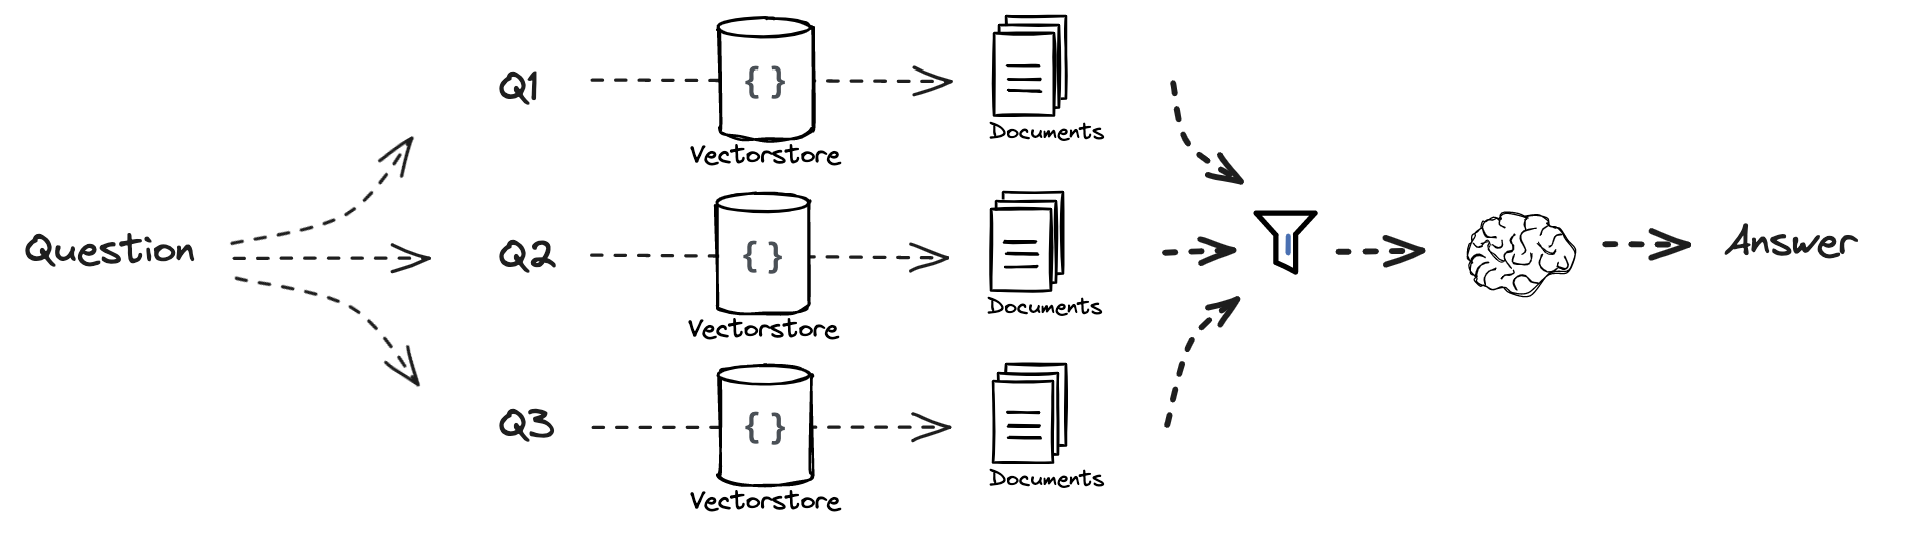

In [4]:
from langchain.prompts import ChatPromptTemplate

# RAG-Fusion: Related
template = """You are a helpful assistant that generates multiple search queries based on a single input query. \n
Generate multiple search queries related to: {question} \n
Output (4 queries):"""
# Would it be interesting to generate questions in both language, to check which language give better retriever ?
prompt_rag_fusion = ChatPromptTemplate.from_template(template)

In [5]:
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI

## Chain to generate 4 different queries
generate_queries = (
    prompt_rag_fusion 
    | ChatOpenAI(temperature=0)  # Here we use ChatGPT to generate the 4 queries. It cost few token, but maybe llama3 is enough?
    | StrOutputParser() 
    | (lambda x: x.split("\n"))
)

#Create a chain with the 4 query generation + retrieval. Output will be a list of lenght 4
retrieval_chain_rag_fusion = generate_queries | retriever.map()

In [6]:
question = "Quel est l'impact des régimes fonciers sur la protection des forêts?"
docs = retrieval_chain_rag_fusion.invoke({"question": question})
len(docs)

4

Generate answer from the 4 retrieved document

In [7]:
from langchain_core.runnables import RunnablePassthrough,RunnableLambda
from langchain_core.output_parsers import StrOutputParser
from operator import itemgetter

from langchain_groq.chat_models import ChatGroq



llm = ChatGroq(temperature=0, model_name="llama3-70b-8192")
#llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0)


# RAG
template = """Answer the following question based on this context:
If you don't know this answer, say it.

Context:
{context}

Question: {question}
"""

prompt = ChatPromptTemplate.from_template(template)

final_rag_chain = (
    {"context": retrieval_chain_rag_fusion, 
     "question": 
     getter("question")} 
    | prompt
    | llm
    | StrOutputParser()
)
print(f"Question : {question}")
final_rag_chain.invoke({"question":question})

Question : Quel est l'impact des régimes fonciers sur la protection des forêts?


"Selon les documents fournis, l'impact des régimes fonciers sur la protection des forêts est complexe et multifacette.\n\nD'une part, les régimes fonciers peuvent favoriser la protection des forêts en reconnaissant les droits des populations locales et autochtones sur les terres et les ressources forestières. Cela peut encourager la gestion durable des forêts et la conservation de la biodiversité.\n\nD'autre part, les régimes fonciers peuvent également entraîner des conflits et des tensions entre les populations locales et les acteurs extérieurs, tels que les gouvernements et les entreprises, qui cherchent à exploiter les ressources forestières. Cela peut entraîner la perte de droits et de contrôle des populations locales sur leurs terres et ressources.\n\nEn outre, les régimes fonciers peuvent également influencer la gouvernance forestière et la gestion des aires protégées. Par exemple, la décentralisation et la délimitation des forêts communales peuvent entraîner des pertes de droits

# RAG FUSION : Reranking
reranking documents retrieved to select the most important one

In [8]:
from langchain.load import dumps, loads

def reciprocal_rank_fusion(results: list[list], k=60):
    """ Reciprocal_rank_fusion that takes multiple lists of ranked documents 
        and an optional parameter k used in the RRF formula """
    
    # Initialize a dictionary to hold fused scores for each unique document
    fused_scores = {}

    # Iterate through each list of ranked documents
    for docs in results:
        # Iterate through each document in the list, with its rank (position in the list)
        for rank, doc in enumerate(docs):
            # Convert the document to a string format to use as a key (assumes documents can be serialized to JSON)
            doc_str = dumps(doc)
            # If the document is not yet in the fused_scores dictionary, add it with an initial score of 0
            if doc_str not in fused_scores:
                fused_scores[doc_str] = 0
            # Retrieve the current score of the document, if any
            previous_score = fused_scores[doc_str]
            # Update the score of the document using the RRF formula: 1 / (rank + k)
            fused_scores[doc_str] += 1 / (rank + k)

    # Sort the documents based on their fused scores in descending order to get the final reranked results
    reranked_results = [
        (loads(doc), score)
        for doc, score in sorted(fused_scores.items(), key=lambda x: x[1], reverse=True)
    ]

    # Return the reranked results as a list of tuples, each containing the document and its fused score
    return reranked_results

retrieval_chain_rag_fusion = generate_queries | retriever.map() | reciprocal_rank_fusion
docs = retrieval_chain_rag_fusion.invoke({"question": question})
len(docs)

/home/guillaume/.cache/pypoetry/virtualenvs/forestbot-QnTDFiWY-py3.10/lib/python3.10/site-packages/langchain_core/_api/beta_decorator.py:87: LangChainBetaWarning: The function `loads` is in beta. It is actively being worked on, so the API may change.
  warn_beta(


12

In [9]:
from langchain_core.runnables import RunnablePassthrough

# RAG
template = """Answer the following question based on this context:

{context}

Question: {question}
"""

prompt = ChatPromptTemplate.from_template(template)

final_rag_chain = (
    {"context": retrieval_chain_rag_fusion, 
     "question": itemgetter("question")} 
    | prompt
    | llm
    | StrOutputParser()
)

final_rag_chain.invoke({"question":question})

"Selon les documents, les régimes fonciers ont un impact significatif sur la protection des forêts. Les droits des populations locales et autochtones sur les terres et les ressources forestières sont souvent remis en question par les régimes fonciers, ce qui peut entraîner la perte de contrôle des communautés sur leurs terres et ressources.\n\nLes régimes fonciers peuvent également favoriser l'accaparement des terres et la déforestation, en particulier lorsque les gouvernements et les entreprises privées cherchent à exploiter les ressources forestières sans prendre en compte les droits et les intérêts des communautés locales.\n\nCependant, les régimes fonciers peuvent également être utilisés pour protéger les forêts et les droits des communautés locales. Par exemple, les législations forestières peuvent reconnaître les droits des populations autochtones et locales sur les terres et les ressources forestières, et établir des mécanismes pour protéger ces droits.\n\nEn outre, les régimes 

# Decomposition
Decompose the question into subquestion. Retrieve answer for one subquestion before going to the next subquestion

In [48]:
from langchain.prompts import ChatPromptTemplate

# Decomposition
template = """You are a helpful assistant that generates multiple sub-questions related to an input question. \n
The goal is to break down the input into a set of sub-problems / sub-questions that can be answers in isolation. \n

----------------
Example :
Question : What are the main components of an LLM-powered autonomous agent system?
Answer:
1. What is LLM technology and how does it work in autonomous agent systems?
2. What are the specific components that make up an LLM-powered autonomous agent system?
3. How do the main components of an LLM-powered autonomous agent system interact with each other to enable autonomous functionality?
---------------

Generate multiple search queries related to: {question} \n
Don't mention anything else before or after, write only the 3 sub-questions


Here are 3 sub-questions related to the input question:"""
prompt_decomposition = ChatPromptTemplate.from_template(template)

In [54]:
from langchain_core.output_parsers import StrOutputParser

# LLM
#llm = ChatOpenAI(temperature=0)
llm = ChatGroq(temperature=0, model_name="llama3-70b-8192")


# Chain
generate_queries_decomposition = ( prompt_decomposition | llm | StrOutputParser() | (lambda x: x.split("\n")))

# Run
question = "Comment les régimes fonciers impactent la protection des forêts? Détaille ta réponse pour chaque pays"
questions = generate_queries_decomposition.invoke({"question":question})

In [55]:
print(questions)
print(prompt_decomposition.invoke({"question":question}))

['1. What are the different types of land tenure regimes and how do they influence forest protection outcomes?', "2. How do the specific characteristics of a country's land tenure regime (e.g. private, public, communal) impact forest protection efforts?", '3. What are the country-specific examples of how land tenure regimes have contributed to or hindered forest protection, and what lessons can be learned from these examples?']
messages=[HumanMessage(content="You are a helpful assistant that generates multiple sub-questions related to an input question. \n\nThe goal is to break down the input into a set of sub-problems / sub-questions that can be answers in isolation. \n\n\n----------------\nExample :\nQuestion : What are the main components of an LLM-powered autonomous agent system?\nAnswer:\n1. What is LLM technology and how does it work in autonomous agent systems?\n2. What are the specific components that make up an LLM-powered autonomous agent system?\n3. How do the main component

In [56]:
# Prompt
template = """Here is the question you need to answer:

\n --- \n {question} \n --- \n

Here is any available background question + answer pairs:

\n --- \n {q_a_pairs} \n --- \n

Here is additional context relevant to the question: 

\n --- \n {context} \n --- \n

Use the above context and any background question + answer pairs to answer the question: \n {question}
"""

decomposition_prompt = ChatPromptTemplate.from_template(template)

In [57]:
from operator import itemgetter
from langchain_core.output_parsers import StrOutputParser

def format_qa_pair(question, answer):
    """Format Q and A pair"""
    
    formatted_string = ""
    formatted_string += f"Question: {question}\nAnswer: {answer}\n\n"
    return formatted_string.strip()

# llm
#llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0)
llm = ChatGroq(temperature=0, model_name="llama3-70b-8192")

q_a_pairs = ""
for q in questions:
    
    rag_chain = (
    {"context": itemgetter("question") | retriever, 
     "question": itemgetter("question"),
     "q_a_pairs": itemgetter("q_a_pairs")} 
    | decomposition_prompt
    | llm
    | StrOutputParser())

    answer = rag_chain.invoke({"question":q,"q_a_pairs":q_a_pairs})
    q_a_pair = format_qa_pair(q,answer)
    q_a_pairs = q_a_pairs + "\n---\n"+  q_a_pair

In [58]:
print(answer)

Based on the provided context and background question + answer pairs, here are some country-specific examples of how land tenure regimes have contributed to or hindered forest protection, and the lessons that can be learned from these examples:

**Example 1: Community-based management in Cameroon**

In Cameroon, community-based management of forests has been successful in protecting forests and biodiversity. The government has devolved management rights to local communities, who have established their own management plans and regulations. This approach has led to more effective forest protection and sustainable use of natural resources. Lesson learned: Community-based management can be an effective approach to forest protection when local communities are involved in decision-making and management.

**Example 2: State ownership in the Democratic Republic of Congo**

In the Democratic Republic of Congo, state ownership of forests has led to top-down decision-making and a lack of communit

# Query translation : Step back
We ask the LLM to generate a more general question, and with retrieve both the specific question and the general question(step back)

Guillaume feeling : the rephrasing is very poor, almost similar to the original question

In [59]:
# Few Shot Examples
from langchain_core.prompts import ChatPromptTemplate, FewShotChatMessagePromptTemplate
examples = [
    {
        "input": "Could the members of The Police perform lawful arrests?",
        "output": "what can the members of The Police do?",
    },
    {
        "input": "Jan Sindel’s was born in what country?",
        "output": "what is Jan Sindel’s personal history?",
    },
]
# We now transform these to example messages
example_prompt = ChatPromptTemplate.from_messages(
    [
        ("human", "{input}"),
        ("ai", "{output}"),
    ]
)
few_shot_prompt = FewShotChatMessagePromptTemplate(
    example_prompt=example_prompt,
    examples=examples,
)
prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You are an expert at world knowledge. Your task is to step back and paraphrase a question to a more generic step-back question, which is easier to answer. Here are a few examples:""",
        ),
        # Few shot examples
        few_shot_prompt,
        # New question
        ("user", "{question}"),
    ]
)

In [65]:
generate_queries_step_back = prompt | ChatOpenAI(temperature=0) | StrOutputParser()
question = "how did IWC handle controversies with local communities regarding land investment in plantations?"
generate_queries_step_back.invoke({"question": question})


'how does IWC address challenges with local communities in land investments?'

In [66]:
from langchain_core.runnables import RunnablePassthrough,RunnableLambda

# Response prompt 
response_prompt_template = """You are an expert of world knowledge. I am going to ask you a question. Your response should be comprehensive and not contradicted with the following context if they are relevant. Otherwise, ignore them if they are not relevant.

# {normal_context}
# {step_back_context}

# Original Question: {question}
# Answer:"""
response_prompt = ChatPromptTemplate.from_template(response_prompt_template)

llm = ChatGroq(temperature=0, model_name="llama3-70b-8192")

chain = (
    {
        # Retrieve context using the normal question
        "normal_context": RunnableLambda(lambda x: x["question"]) | retriever,
        # Retrieve context using the step-back question
        "step_back_context": generate_queries_step_back | retriever,
        # Pass on the question
        "question": lambda x: x["question"],
    }
    | response_prompt
    | llm
    | StrOutputParser()
)

answer = chain.invoke({"question": question})
print(answer)

Based on the provided context, it appears that the International Wildlife Conservation (IWC) handled controversies with local communities regarding land investment in plantations by adopting a more inclusive and participatory approach. Here are some key points that suggest this:

1. **Recognition of past mistakes**: The text acknowledges that the historical form of governance often favored legal and institutional tools of repression and eviction of populations, leading to conflicts between conservation officers and local communities. This recognition implies that IWC has learned from its past mistakes and is willing to adopt a more collaborative approach.

2. **Inclusive governance**: The text highlights examples of Central African countries adopting a government-led governance system that leaves room for consultation, aiming to better integrate communities and improve management efficiency. This suggests that IWC is moving towards a more inclusive governance model that involves local 